# Collaboration and Competition

---


### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from unityagents import UnityEnvironment

%matplotlib inline

Load the environment.

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [8]:
def ddpg(n_episodes=1000, max_t=1000, solved_score=0.5, consec_episodes=100, print_every=10, train_mode=True,
         actor_path='actor_ckpt.pth', critic_path='critic_ckpt.pth'):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """
    instant_scores = [] 
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        instant_scores.append(np.max(scores))           # save mean score for the episode
        scores_window.append(instant_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} \tInst. Reward: {:.3f}\tAvg. Reward: {:.3f}'.format(\
                  i_episode, instant_scores[-1], moving_avgs[-1]))
                  
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.3f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_avgs[-1], consec_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path) 
            break
            
    return instant_scores, moving_avgs

In [9]:
from workspace_utils import active_session

# run the training loop
with active_session():
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
    scores, avgs = ddpg()

Episode 10 	Inst. Reward: 0.100	Avg. Reward: 0.010
Episode 20 	Inst. Reward: 0.000	Avg. Reward: 0.010
Episode 30 	Inst. Reward: 0.100	Avg. Reward: 0.019
Episode 40 	Inst. Reward: 0.000	Avg. Reward: 0.019
Episode 50 	Inst. Reward: 0.100	Avg. Reward: 0.026
Episode 60 	Inst. Reward: 0.000	Avg. Reward: 0.034
Episode 70 	Inst. Reward: 0.100	Avg. Reward: 0.039
Episode 80 	Inst. Reward: 0.000	Avg. Reward: 0.037
Episode 90 	Inst. Reward: 0.000	Avg. Reward: 0.037
Episode 100 	Inst. Reward: 0.090	Avg. Reward: 0.041
Episode 110 	Inst. Reward: 0.100	Avg. Reward: 0.046
Episode 120 	Inst. Reward: 0.090	Avg. Reward: 0.051
Episode 130 	Inst. Reward: 0.100	Avg. Reward: 0.057
Episode 140 	Inst. Reward: 0.000	Avg. Reward: 0.068
Episode 150 	Inst. Reward: 0.090	Avg. Reward: 0.073
Episode 160 	Inst. Reward: 0.100	Avg. Reward: 0.076
Episode 170 	Inst. Reward: 0.100	Avg. Reward: 0.079
Episode 180 	Inst. Reward: 0.000	Avg. Reward: 0.085
Episode 190 	Inst. Reward: 0.100	Avg. Reward: 0.094
Episode 200 	Inst. Re

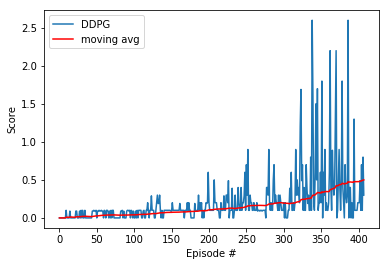

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()